# Multiple - Hyperspectral image analysis and classification

In [1]:
%%capture
!python -m pip install -U abraia

import os
if not os.getenv('ABRAIA_ID') or not os.getenv('ABRAIA_KEY'):
    #@markdown <a href="https://abraia.me/console/" target="_blank">Get your Abraia Id and Key</a>
    abraia_id = ''  #@param {type: "string"}
    abraia_key = ''  #@param {type: "string"}
    %env ABRAIA_ID=$abraia_id
    %env ABRAIA_KEY=$abraia_key

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from abraia import Multiple, hsi

plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

multiple = Multiple()

2021-10-18 22:05:28.244565: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-10-18 22:05:28.244614: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Load the HSI dataset

We load the Indian Pines (IP) hyperspectral image dataset and we visualize some random bands. It was gathered using the AVIRIS sensor over the Indian Pines test site in North-western Indiana and it consists of and image of 145 X 145 pixels and 200 spectral bands, with 16 labels over the image.

In [2]:
hsiImg, gt, class_names = hsi.load_dataset('IP')

print(f'HSI image size (width, height, bands): {hsiImg.shape}')
summary = pd.DataFrame([{'class_name': label, 'samples': np.sum(gt == val)} for val, label in enumerate(class_names)])
summary.iloc[1:]

HSI image size (width, height, bands): (145, 145, 200)


,class_name,samples
1,Alfalfa,46
2,Corn-notill,1428
3,Corn-mintill,830
4,Corn,237
5,Grass-pasture,483
6,Grass-trees,730
7,Grass-pasture-mowed,28
8,Hay-windrowed,478
9,Oats,20
10,Soybean-notill,972


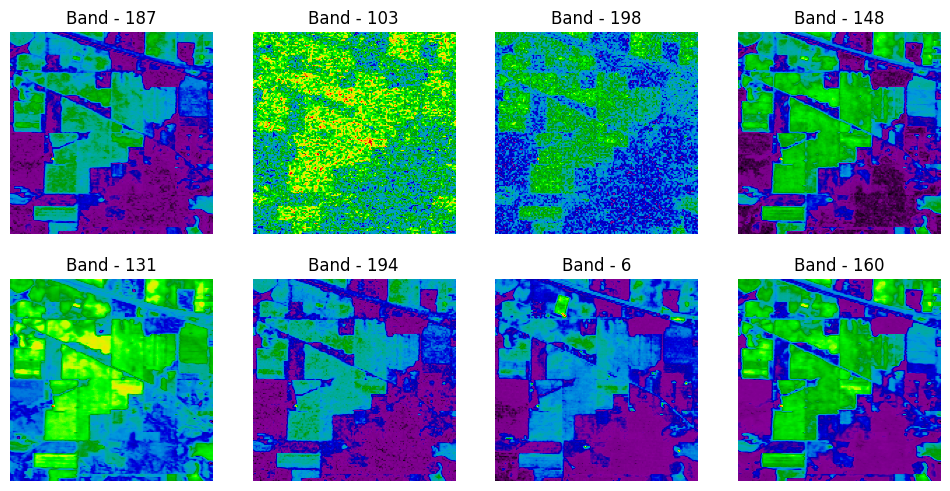

In [3]:
imgs, indexes = hsi.random(hsiImg, n_bands=8)
titles = [f"Band - {indexes[i]}" for i in range(len(imgs))]

ax = plt.subplots(2, 4)[1].reshape(-1)
for i, img in enumerate(imgs):
    ax[i].title.set_text(titles[i])
    ax[i].imshow(img, cmap='nipy_spectral')
    ax[i].axis('off')

## Dimensionality reduction (PCA) and visualization

We analyze the redundancy in the data available using PCA decomposition.

Text(0, 0.5, 'Cumulative explained variance')

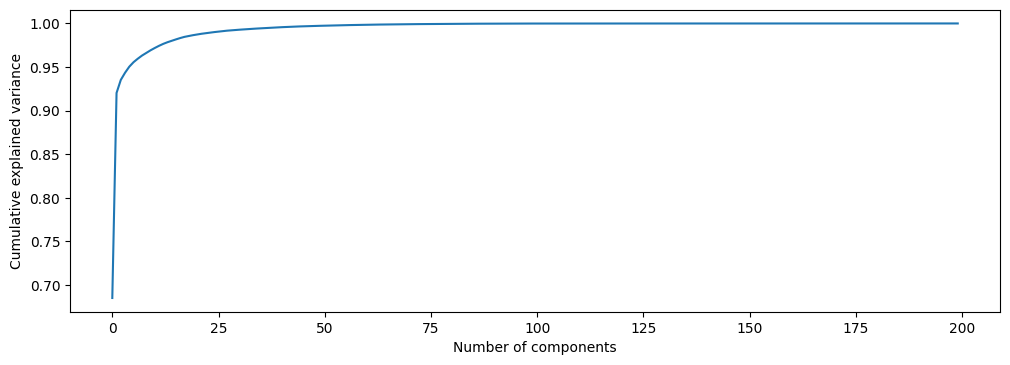

In [4]:
from sklearn.decomposition import PCA

# Transform image to array of samples (with corresponding spectra) and ground truth to array of labels 
X, y = hsiImg, gt
r, c, d = X.shape
X = X.reshape((r * c), d)
y = y.reshape((r * c))

pca = PCA()
pcX = pca.fit_transform(X)
ev=pca.explained_variance_ratio_

fig = plt.figure(figsize=(12, 4))
plt.plot(np.cumsum(ev))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

The curve shows that practically all variance is explained with the first 50 principal components. The rest of them are likely to contain mostly noise.

So, we may simplify the job to the SVM model by reducing redundancy and decorrelation across spectral bands. We use the reduced bands result of the PCA to feed the classifier, removing noise and irrelevant information that won't improve the performance of our clasifier. But even if we don't want to apply a reduction of the number of components, decorrelating the bands before feeding the classifier is a good practice with classic classfifiers like support vector machines. With the IP dataset, it improves performace by a 10%.

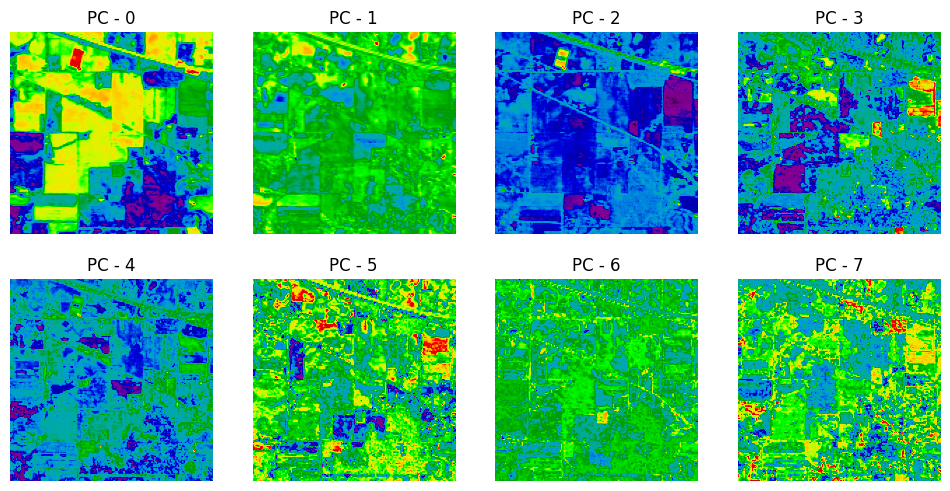

In [5]:
X = hsi.principal_components(hsiImg, n_components=40)

ax = plt.subplots(2, 4)[1].reshape(-1)
for i in range(8):
    ax[i].title.set_text(f'PC - {i}')
    ax[i].imshow(X[:,:,i], cmap='nipy_spectral')
    ax[i].axis('off')

# SVM training

In [6]:
model = hsi.create_model('svm')
y_test, y_pred = model.train(X, y, train_ratio=0.7)

print('Overall accuracy', hsi.accuracy_score(y_test, y_pred))
print(hsi.classification_report(y_test, y_pred, target_names=class_names))
print(hsi.confusion_matrix(y_test, y_pred))

Overall accuracy 0.7682308180088776
                              precision    recall  f1-score   support

                                   0.81      0.85      0.83      3233
                     Alfalfa       1.00      0.64      0.78        14
                 Corn-notill       0.69      0.67      0.68       428
                Corn-mintill       0.78      0.66      0.72       249
                        Corn       0.60      0.51      0.55        71
               Grass-pasture       0.86      0.76      0.81       145
                 Grass-trees       0.83      0.78      0.80       219
         Grass-pasture-mowed       0.57      0.50      0.53         8
               Hay-windrowed       0.87      0.91      0.89       143
                        Oats       0.67      0.33      0.44         6
              Soybean-notill       0.70      0.67      0.69       292
             Soybean-mintill       0.75      0.75      0.75       737
               Soybean-clean       0.77      0.65    

## Classification result

<Figure size 1200x600 with 0 Axes>

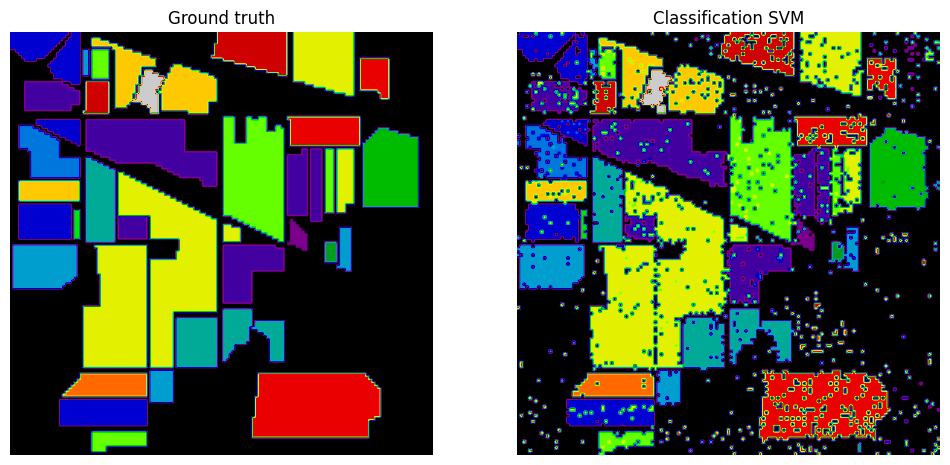

In [7]:
clmap = model.predict(X)

hsi.plot_images([gt, clmap], ['Ground truth', 'Classification SVM'])